In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

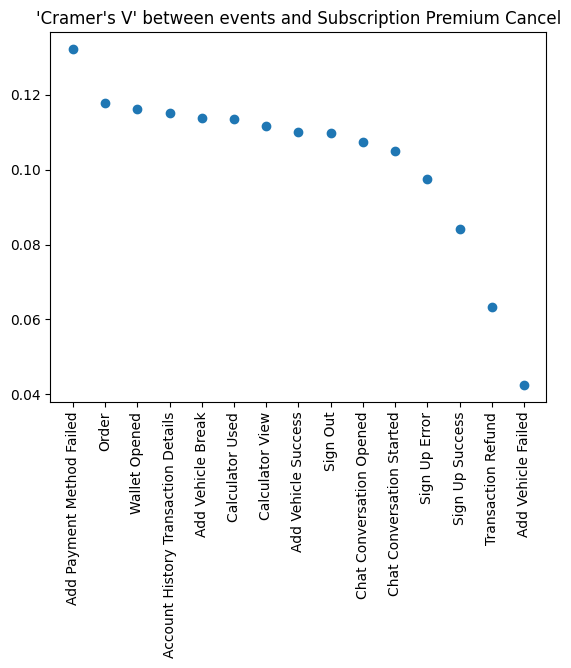

Events with highest correlation with Subscription Premium Cancel are ('Add Payment Method Failed', 'Order', 'Wallet Opened')
Events with lowest correlation with Subscription Premium Cancel are ('Sign Up Success', 'Transaction Refund', 'Add Vehicle Failed')


In [2]:
# Load data
df = pd.read_csv("int20h-ds-test-dataset.csv")

# Get only those users who once cancelled their subscription
user_id = df[df["event_name"] == "Subscription Premium Cancel"]["userid"].unique()
df = df[df["userid"].isin(user_id)]

# Remove events not significant for cancellation
df = df[~df["event_name"].isin(["Subscription Premium", 
"Add Payment Method Success", 
"Signup Success", 
"Account Setup Skip", 
"Subscription Premium Renew", 
"Email Confirmation Success",
"Signup Error",
"Account Setup Profile Skip"])]

# Our target event to calculate correlation of other events with
e = 'Subscription Premium Cancel'

# Group data by user_id and calculate counts of each event_name
grouped = df.groupby('userid').agg({'event_name': 'count'})
grouped = grouped.rename(columns={'event_name': e})

# Calculate contingency table for each event_name and Subscription Premium Cancel
for event in df['event_name'].unique():
    if event != e:
        event_counts = df[df['event_name'] == event].groupby('userid').agg({'event_name': 'count'})
        event_counts = event_counts.rename(columns={'event_name': event})
        grouped = grouped.merge(event_counts, on='userid', how='left')

# Fill missing values with 0
grouped = grouped.fillna(0)

correlations = []

# Calculate Cramer's V for each pair of event_name and Subscription Premium Cancel
N = grouped.sum().sum()
for col in grouped.columns:
    if col != e:
        crosstab = pd.crosstab(grouped[e], grouped[col])
        chi2 = chi2_contingency(crosstab, correction=False)[0]
        phi2 = chi2 / N
        r, k = crosstab.shape
        cramer = np.sqrt(phi2 / min(r - 1, k - 1))
        correlations.append((col, cramer))
        # print("Cramer's V between {} and Subscription Premium Cancel: {}".format(col, cramer))

# Plot result correlations
x, y = zip(*sorted(correlations, key=lambda x: x[1], reverse=True))
plt.scatter(x, y)
plt.xticks(rotation = 90)
plt.title(f"'Cramer's V' between events and {e}")
plt.show()

# Output events with highest and lowest correlation with Subscription Premium Cancel
print(f"Events with highest correlation with {e} are {x[:3]}")
print(f"Events with lowest correlation with {e} are {x[-3:]}")

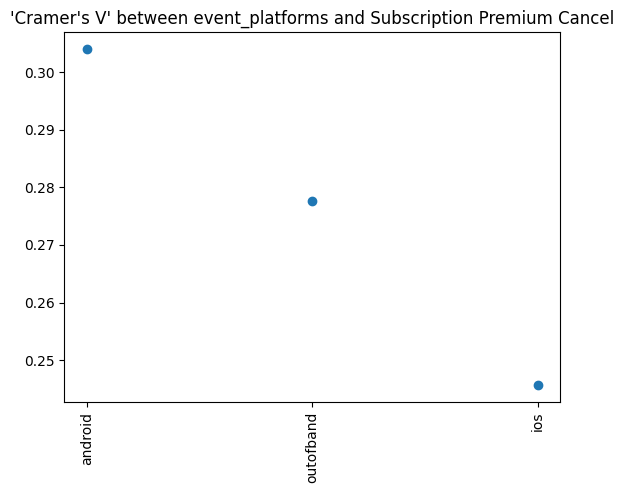

Chi-Squared Test Statistic: 578.5551731884705
Platforms: ('android', 'outofband', 'ios')
Cramer's V: (0.30398386932666055, 0.27755715170365713, 0.2456708781823014)


In [7]:
# Test correlation for parameter "event_platform"
parameter = "event_platform"
df = pd.read_csv("int20h-ds-test-dataset.csv")
df["cancelled"] = (df["event_name"] == "Subscription Premium Cancel").astype(int)

df[[parameter]] = df[[parameter]].fillna(value=0)

# Create the contingency table
ctab = pd.crosstab(df["cancelled"], df[parameter])

# Calculate the chi-squared test statistic
chi2, p, dof, expected = chi2_contingency(ctab)

# Calculate Cramer's V
phi2 = chi2/sum(expected)
phi = np.sqrt(phi2)

results = [(ctab.axes[1].values[i], phi[i]) for i in range(len(phi))]
x, y = zip(*sorted(results, key=lambda x: x[1], reverse=True))
plt.scatter(x, y)
plt.xticks(rotation = 90)
plt.title(f"'Cramer's V' between {parameter}s and {e}")
plt.show()

print("Chi-Squared Test Statistic:", chi2)
print("Platforms:", x)
print("Cramer's V:", y)